# Table of Contents

[Halfwidth manual adjustment](#1) <br>
[Capacitance manual adjustment](#2) <br>
[Adding a parameter to QC datatables](#3) <br>

<br>

[Analysis mouse experiments](#4) <br>
[Analysis miniML averages output](#5) <br>
[Prepare files for analysis with Barbara's algorithm - manual analysis](#6) <br>

## Halfwidth manual adjustment <a name= "1">
    
 1st definition can be played around with the TH speed, if the TH was detected before the actual TH.

2nd definition the lower and upper bounds can be adjusted, if, for example, the AP is very fast and there are not enough datapoints between .3 and .7

In [12]:
from ephys_analysis import funcs_sorting as sort
from ephys_analysis import funcs_human_characterisation as hcf
from ephys_analysis.detect_peaks import detect_peaks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [9]:
def get_ap_param(charact_data, channels, inj, max_spikes, peak_loc_x, th_sp):
    '''
    returns a nd.array with inj, peak loc, sweep numx
    spike_counts for each inj
    array with all peak locations [inj, peak, sweep num]
    peak_loc_x defines how wide the AP is defined around the peak, how many datapoints,
    smaller values certainly catch only 1 AP
    '''
    params = [Rheobase_all, AP_all, THloc_all, TH_all, APheight_all, max_depol_all, \
              max_repol_all] = [[], [], [], [], [], [], []]
    for a, ch in enumerate(channels):
        key = 'Ch' + str(ch)  
        ch1 = charact_data[key][0]        
        peaks = np.empty([len(inj), max_spikes[a], 3])
        peaks.fill(np.nan)
        for i in range(len(ch1[0])): #for all swps
            pks = detect_peaks(ch1[:,i], mph=20,mpd=50) 
            peaks[i,0:len(pks), 0] = inj[i] #injected current
            peaks[i,0:len(pks), 1] = pks #
            peaks[i,0:len(pks), 2] = ch1[pks,i] #sweep number
            # number of spikes in each step
        spike_counts = np.ndarray([len(inj), 2])
        for i, j in enumerate(inj):
            spike_counts[i, 0] = j
            spike_counts[i, ] = (np.sum(np.isfinite(peaks[i,:,:])))/3

    spikes = np.where(np.isfinite(peaks))  
    first_spike = spikes[0][0]
    Rheobase = inj[first_spike] 

    if np.max(spike_counts[:,1]) == 1:
        print('MAX number of AP = 1 for ' + key)
        first_spiking_sweep = np.where(spike_counts[:,1]==1)[0][0]
    else:
        first_spiking_sweep = np.where(spike_counts[:,1]>1)[0][0] #where there is more than 1 AP
    
    if np.max(spike_counts[:,1]) == 1:
        ap = 0
    else:
        ap = 1
            
    peak_loc = np.where(ch1[:,first_spiking_sweep] == peaks[first_spiking_sweep, ap ,2])[0][0]
    AP = ch1[:, first_spiking_sweep][peak_loc - peak_loc_x:peak_loc+peak_loc_x]
    d1_AP = np.diff(AP)*20
    THlocs = np.where(d1_AP[:peak_loc_x] > th_sp)

    if THlocs[0].size != 0:
        THloc = THlocs[0][0]
        TH = AP[THloc-1]
        APheight = peaks[first_spiking_sweep, ap ,2]-TH   
        max_depol = np.max(d1_AP[:200]) #how quickly is the voltage change occuring
        max_repol = np.min(d1_AP[-200:])
        ch_params = [Rheobase, AP, THloc, TH, APheight, max_depol, max_repol]           
        
        for i, param in enumerate(params):
                param.append(ch_params[i])


    return Rheobase_all, AP_all, THloc_all, TH_all, APheight_all, max_depol_all, max_repol_all

            

def get_AP_HW(channels, AP_all, APheight_all, TH_all, lower_bound=0.1, upper_bound=0.9):
    '''
    returns AP halfwidt in ms at 1/2   of the AP amplitude,
    measured from AP threshold to AP peak
    '''
            
    AP_HWs = []
    for i, ch in enumerate(channels):
        if len(AP_all[i]) == 0 or math.isnan(APheight_all[i]) or APheight_all[i] < 25:
            AP_HWs.append(math.nan)
            continue

        half_amp = TH_all[i] + APheight_all[i]/2
            
        t30 = TH_all[i] + APheight_all[i] * lower_bound
        t70 = TH_all[i] + APheight_all[i] * upper_bound

        rise_start = np.where(AP_all[i] > t30)[0][0]
        rise_end = np.where(AP_all[i] > t70)[0][0]

        x = range(rise_start, rise_end)
        y = AP_all[i][rise_start:rise_end]
            
        model_rise = np.polyfit(x, y, 1)
        hw1 = (half_amp - model_rise[1])/model_rise[0] 

        fall_start = np.where(AP_all[i] > t30)[0][-1]
        fall_end = np.where(AP_all[i] > t70)[0][-1]

        x_fall = range(fall_end, fall_start)
        y_fall = AP_all[i][fall_end:fall_start]

        model_fall = np.polyfit(x_fall, y_fall, 1)
        hw2 = (half_amp - model_fall[1])/model_fall[0]

        AP_HWs.append((hw2-hw1)/20) #conversion to ms

        predict_rise = np.poly1d(model_rise)
        rise_prediction = predict_rise(np.linspace(rise_start, rise_end, 30))
        difference_array = np.absolute(
            np.linspace(rise_start, rise_end, 30)-hw1)
        index_rise = difference_array.argmin()
        hw1_y = rise_prediction[index_rise]

        predict_fall = np.poly1d(model_fall)
        fall_prediction = predict_fall(np.linspace(fall_end, fall_start, 30))
        difference_array = np.absolute(
            np.linspace(fall_end, fall_start, 30)-hw2)
        index_fall = difference_array.argmin()
        hw2_y = fall_prediction[index_fall]

    return AP_HWs, rise_start, rise_end, rise_prediction, fall_end, fall_start, fall_prediction, hw1, hw2, hw1_y, hw2_y

[np.float64(1.02723015205747)]


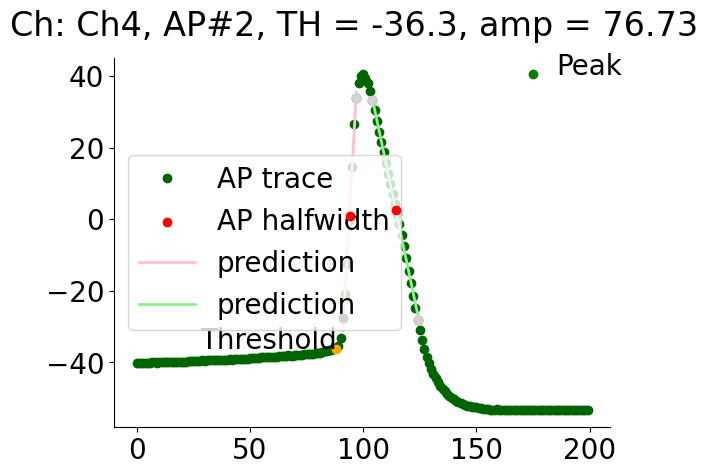

In [25]:
fn = '24926080.abf' 
channels = [3]

file_path = path[:path.rfind('data_tables')] + fn 
end_fn = file_path.rfind('/') + 1
dir_ap_HW = sort.make_dir_if_not_existing(file_path[:end_fn] + 'plots/',  'AP_HW')
channels = [int(df.cell_ch[i])]
charact_data = hcf.load_traces(file_path)
inj = hcf.get_inj_current_steps(file_path)
max_spikes = hcf.get_max_spikes(charact_data, channels)
first_spikes, peaks_all, spike_counts_all, first_spiking_sweeps_all = hcf.get_ap_param_for_plotting(charact_data, channels, inj, max_spikes)

#using the adjusted version of the functions, above
Rheobase_all, AP_all, THloc_all, TH_all, APheight_all, max_depol_all, max_repol_all = \
    get_ap_param(charact_data, channels, inj, max_spikes, peak_loc_x, th_speed)
AP_HWs, rise_start, rise_end, rise_prediction, fall_end, fall_start, fall_prediction, hw1, hw2, hw1_y, hw2_y =\
    get_AP_HW(channels, AP_all, APheight_all, TH_all)

key = 'Ch' + str(channels[0])
ch_data = charact_data[key][0]


if np.max(spike_counts_all[0][:,1]) == 1:
    ap = 0
else:
    ap = 1

fig, ax = plt.subplots()
ax.plot(AP_all[0], 'o', zorder = 0, label = 'AP trace')
ax.scatter(THloc_all[0],TH_all[0], color = 'orange')
    
ax.scatter(175,peaks_all[0][first_spiking_sweeps_all[0], ap, 2], color = 'green')
ax.scatter([hw1, hw2], [hw1_y, hw2_y], c = 'red', zorder = 10, label = 'AP halfwidth')
ax.scatter([rise_start, rise_end, fall_start, fall_end],\
    [AP_all[0][rise_start], AP_all[0][rise_end], AP_all[0][fall_start], AP_all[0][fall_end]],\
        c = 'lightgrey', zorder = 11)
ax.plot(np.linspace(rise_start, rise_end, 30), rise_prediction, c = 'pink', label = 'prediction')
ax.plot(np.linspace(fall_end, fall_start, 30), fall_prediction, c ='lightgreen', label = 'prediction')

ax.text(THloc_all[0] - 60,TH_all[0], 'Threshold')

#d
ax.text(185,peaks_all[0][first_spiking_sweeps_all[0], ap, 2], 'Peak')

ax.legend()
fig.suptitle('Ch: ' + key + ', AP#' + str(ap+1) + ', TH = ' + str(round(TH_all[0],2)) + ', amp = ' + str(round(APheight_all[0],2)))
fig.patch.set_facecolor('white') 
plt.savefig(dir_ap_HW + '/' + file_path[end_fn:-4] + '_HW_AP#' + str(ap+1) + '_' + key + '.png')
#plt.show()
fns.append(fn)
chans.append(channels[0])
HWs.append(AP_HWs[0])

print(AP_HWs)

MAX number of AP = 1 for Ch4


IndexError: index 0 is out of bounds for axis 0 with size 0

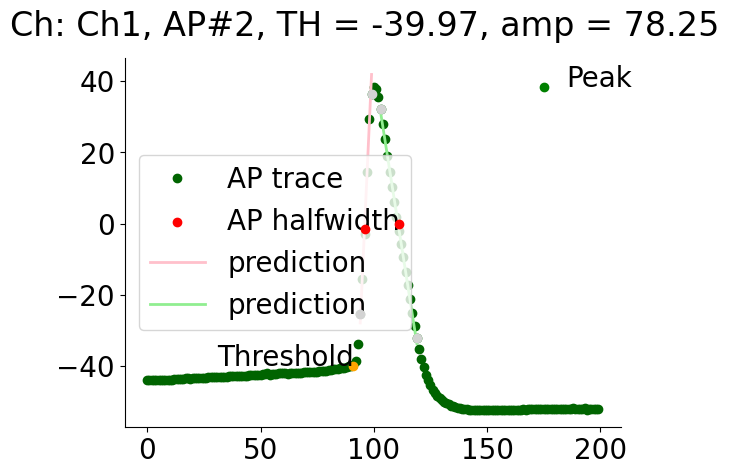

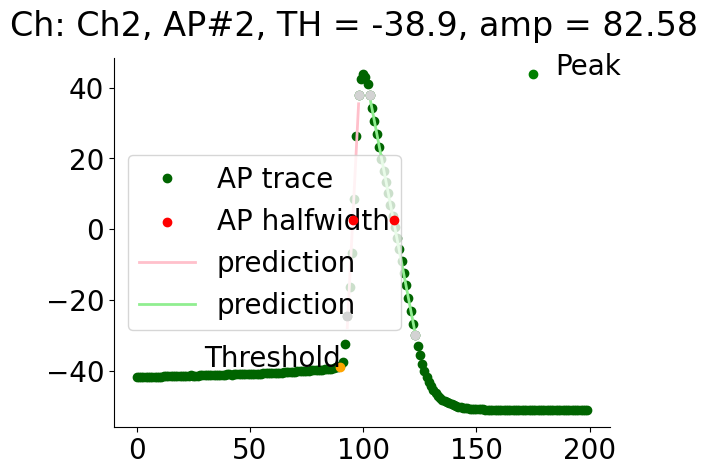

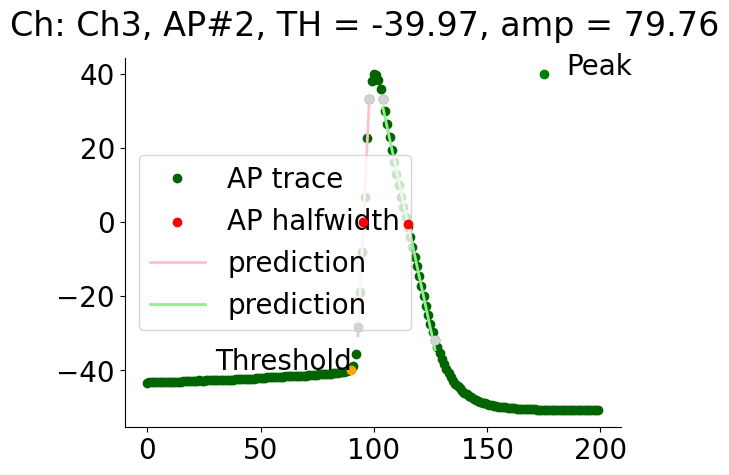

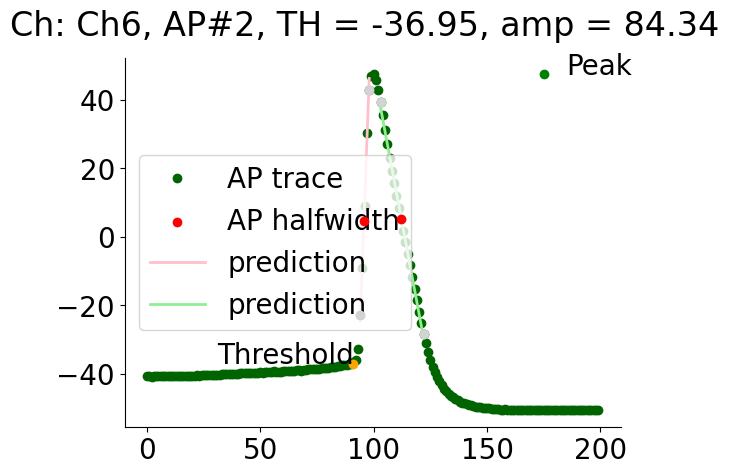

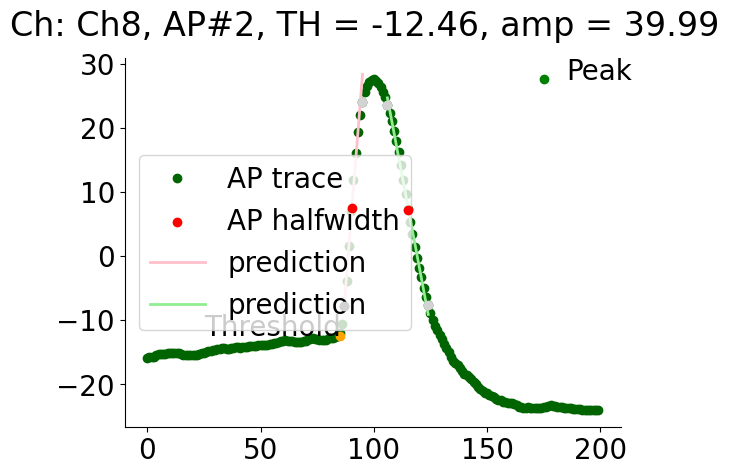

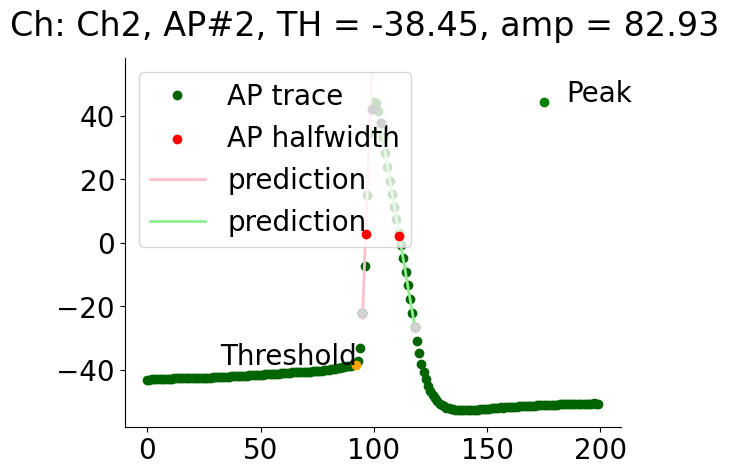

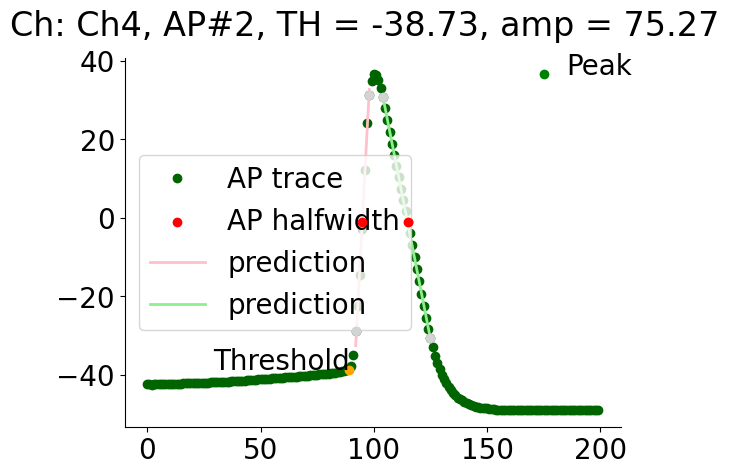

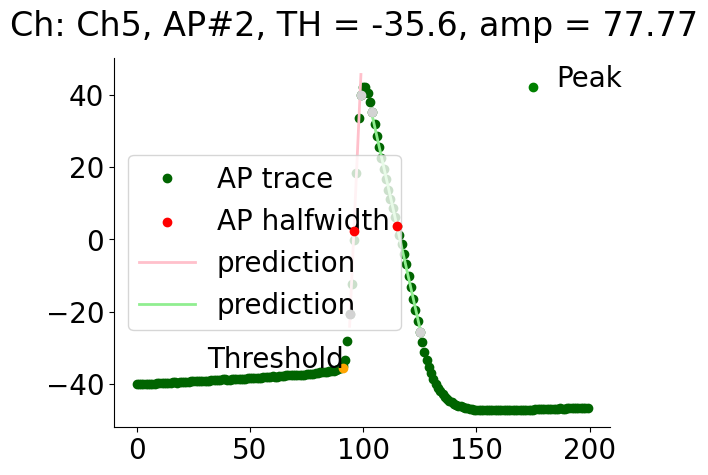

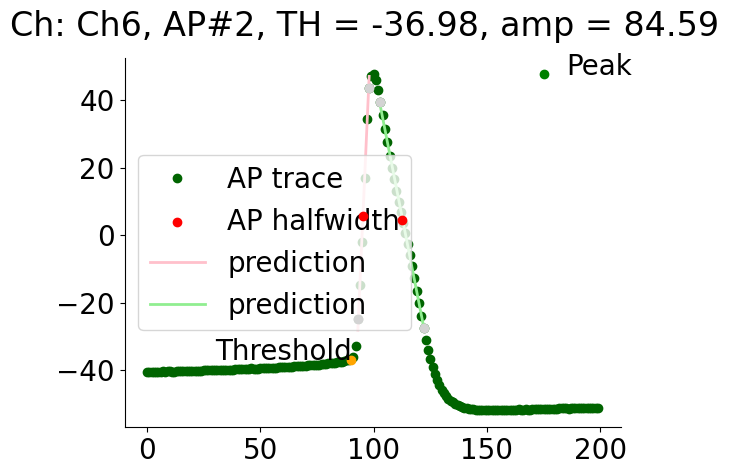

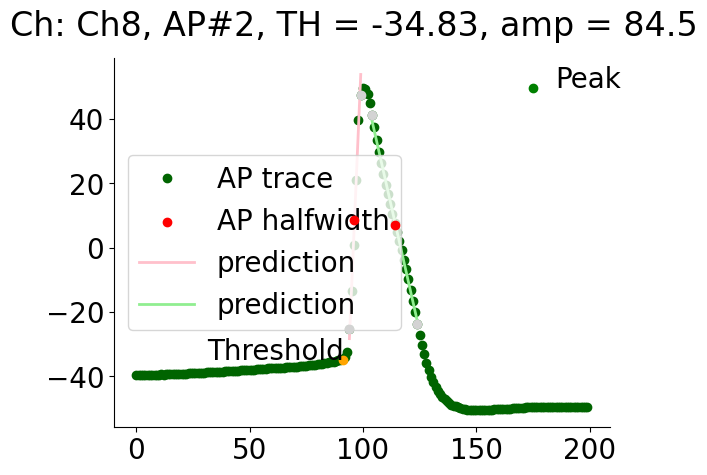

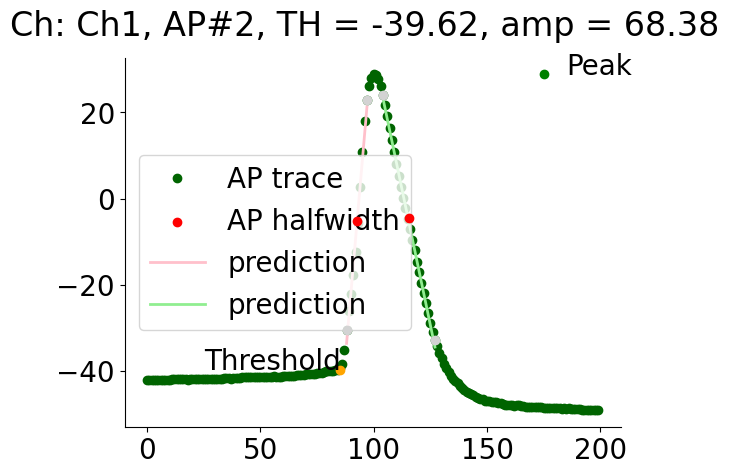

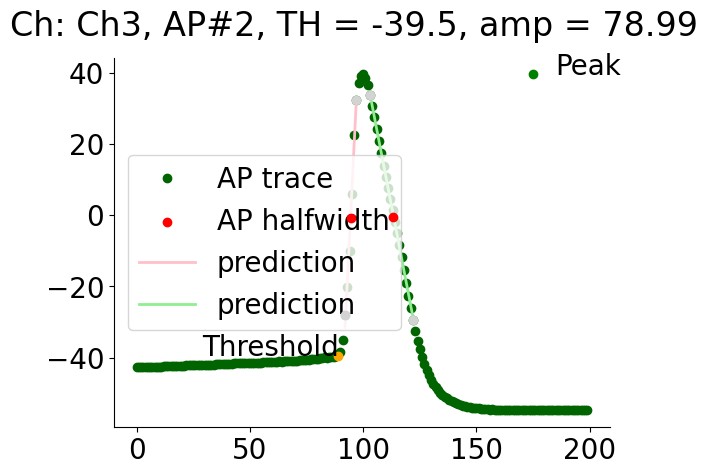

In [ ]:
#do it for all  files
#      AP HALFWIDTH - plot for QC check dataframes
#      line 53 the peak location might need changing

peak_loc_x = 100
th_speed = 10

human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
#intr_props_dirs = glob.glob(human_dir + '/data_*/' + 'OP*' + '/data_tables/' + 'QC_passed' + '*.xlsx')
intr_props_dirs = ['/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/data_verji/OP240926/data_tables/QC_passed_OP240926_Intrinsic_and_synaptic_properties.xlsx']

HWs, fns, chans = [], [], []
path = intr_props_dirs[0]
df = pd.read_excel(intr_props_dirs[0])

for i, fn in enumerate(df['filename']):

    file_path = path[:path.rfind('data_tables')] + fn 
    end_fn = file_path.rfind('/') + 1
    dir_ap_HW = sort.make_dir_if_not_existing(file_path[:end_fn] + 'plots/',  'AP_HW')
    channels = [int(df.cell_ch[i])]
    charact_data = hcf.load_traces(file_path)
    inj = hcf.get_inj_current_steps(file_path)
    max_spikes = hcf.get_max_spikes(charact_data, channels)
    if df['max_spikes'][i] == 0:
        HWs.append(math.nan)
        continue
    first_spikes, peaks_all, spike_counts_all, first_spiking_sweeps_all = hcf.get_ap_param_for_plotting(charact_data, channels, inj, max_spikes)
    
    #using the adjusted version of the functions, above
    Rheobase_all, AP_all, THloc_all, TH_all, APheight_all, max_depol_all, max_repol_all = \
        get_ap_param(charact_data, channels, inj, max_spikes, peak_loc_x, th_speed)
    AP_HWs, rise_start, rise_end, rise_prediction, fall_end, fall_start, fall_prediction, hw1, hw2, hw1_y, hw2_y =\
        get_AP_HW(channels, AP_all, APheight_all, TH_all)
    
    if type(rise_start) is list:
        continue
    key = 'Ch' + str(channels[0])
    ch_data = charact_data[key][0]

    if math.isnan(first_spikes[0]):
        continue

    if np.max(spike_counts_all[0][:,1]) == 1:
        ap = 0
    else:
        ap = 1

    fig, ax = plt.subplots()
    ax.plot(AP_all[0], 'o', zorder = 0, label = 'AP trace')
    ax.scatter(THloc_all[0],TH_all[0], color = 'orange')
        
    ax.scatter(175,peaks_all[0][first_spiking_sweeps_all[0], ap, 2], color = 'green')
    ax.scatter([hw1, hw2], [hw1_y, hw2_y], c = 'red', zorder = 10, label = 'AP halfwidth')
    ax.scatter([rise_start, rise_end, fall_start, fall_end],\
        [AP_all[0][rise_start], AP_all[0][rise_end], AP_all[0][fall_start], AP_all[0][fall_end]],\
            c = 'lightgrey', zorder = 11)
    ax.plot(np.linspace(rise_start, rise_end, 30), rise_prediction, c = 'pink', label = 'prediction')
    ax.plot(np.linspace(fall_end, fall_start, 30), fall_prediction, c ='lightgreen', label = 'prediction')

    ax.text(THloc_all[0] - 60,TH_all[0], 'Threshold')
    
    #d
    ax.text(185,peaks_all[0][first_spiking_sweeps_all[0], ap, 2], 'Peak')

    ax.legend()
    fig.suptitle('Ch: ' + key + ', AP#' + str(ap+1) + ', TH = ' + str(round(TH_all[0],2)) + ', amp = ' + str(round(APheight_all[0],2)))
    fig.patch.set_facecolor('white') 
    plt.savefig(dir_ap_HW + '/' + file_path[end_fn:-4] + '_HW_AP#' + str(ap+1) + '_' + key + '.png')
    #plt.show()
    fns.append(fn)
    chans.append(channels[0])
    HWs.append(AP_HWs[0])

df33 = pd.DataFrame({'files': fns, 'chans': chans, 'AP_HW': HWs})

In [9]:
df33 = pd.DataFrame({'files': fns, 'chans':chans, 'AP_HW': HWs})
df33

,files,chans,AP_HW
0,24417004.abf,Ch1,0.778337
1,24417004.abf,Ch2,0.867837
2,24417004.abf,Ch4,0.951496
3,24417004.abf,Ch5,0.840315
4,24417004.abf,Ch6,0.965131
5,24417004.abf,Ch7,0.862882
6,24417004.abf,Ch8,0.855474
7,24417018.abf,Ch1,0.853323
8,24417018.abf,Ch2,0.786915
9,24417018.abf,Ch4,0.915764


In [ ]:
#      print the parameters and change them in the QC_intrinsic properties dataframe

params = [max_spikes, Rheobase_all, APheight_all, TH_all, mx_depol_ all, max_repol_all, AP_HWs]
 
for param in params:
    my_var_name = [k for k, v in locals().items() if v is param][0]
    print(my_var_name, ' = ', str(param[0]))

max_spikes  =  1
Rheobase_all  =  900.0
APheight_all  =  47.503662109375
TH_all  =  -31.494140625
max_depol_all  =  58.59375
max_repol_all  =  -25.5126953125
AP_HWs  =  1.571762390357668


## Capacitance manual adjustemnt  <a name= "2">
    
Sometimes an artifact causes problems
To overcome them, we just take the second datapoint after the onset (line 36)

The inj is [-300.0, -200.0, -150.0, -100.0, -50.0]
[[7.7500 58.9193 131535911602209939502982527844200537366943735218176.0000
  -300.0000]
 [3.6000 43.7317 82320167480809505627729787736096243712.0000 -200.0000]
 [15.6500 78.9388 198254845360824751212199936.0000 -150.0000]
 [-127.4500 2.8076 -45394365217391312.0000 -100.0000]
 [8.6500 90.3320 95.7578 -50.0000]] ch 3
time const    resistance   capacitance injection


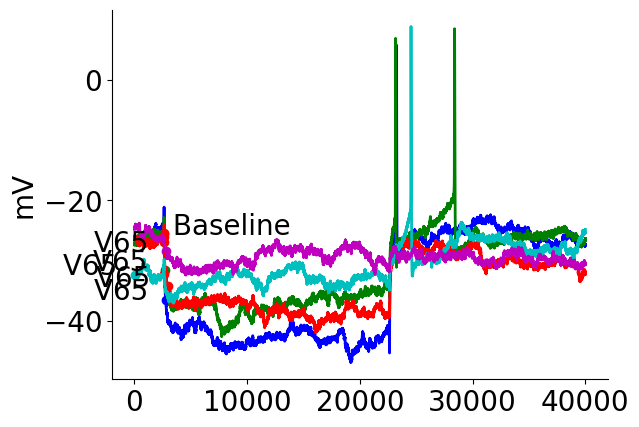

<Figure size 640x480 with 0 Axes>

In [38]:
human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
OP = 'OP240926'
patcher = 'Verji'


work_dir, filenames, indices_dict, slice_names, ch1, ch2 = sort.get_OP_metadata(human_dir, OP, patcher)

fn = work_dir + '24926068.abf' #caracterization filename
inj = hcf.get_inj_current_steps(fn)
chans = [3] #

print('The inj is', inj[:5])

params = tau_all, capacitance_all, mc_all, V65_all = [], [], [], []
onset, offset = hcf.find_charact_onset_offset(fn)

charact_data = hcf.load_traces(fn)
mc = np.ndarray([5,3])
for ch in chans:
    key = 'Ch' + str(ch)
    ch1 = charact_data[key][0]
    V65s = []
    mc = np.ndarray([5,4])
    for i in range(0,5):
        I = inj[i]*1e-12 #check step size
        bl = np.median(ch1[0:onset-20,i])
        ss = np.median(ch1[offset-2000:offset-1,i]) #steady state, during the current step
        swp = list(ch1[:,i])
        Vdiff = bl-ss #voltage deflection size
        v65 = Vdiff * 0.63
        V65 = bl - v65
        V65s.append(V65)
        if list(filter(lambda ii: ii < V65, swp)) == []:
            continue
        else:
            #
            res = list(filter(lambda ii: ii < V65, swp))[1] #takes the first value in swp < V65
            tau65 = swp.index(res) #index of res
            R = (Vdiff/1000)/-I     
            tc = tau65 - onset
            mc[i,0] = tc * 0.05 #membranec capacitance; tc - time constant
            mc[i,1] = R * 1e-6 #resistance
            mc[i,2] = tc * 5e-5 / R #capacitance
        mc[:,3] = inj[:5]
        mc[:,2] = mc[:,2]/1e-12  
        tau = mc[1,0]
        capacitance = mc[1,2]
        ch_params = [tau, capacitance, mc, V65s]

        for i, param in enumerate(params):
            param.append(ch_params[i])

    np.set_printoptions(suppress=True, formatter={'float_kind': '{:.4f}'.format})
    print(mc, 'ch', str(ch))
    print('time const', '   resistance  ', 'capacitance', 'injection')

clrs = ["b", "g", "r", "c", "m", "y", "#FF4500", "#800080"]

end_fn = fn.rfind('/') +1 

tau_all, capacitance_all, mcs, V65s = tau_all, capacitance_all, mc_all, V65_all
for n, ch in enumerate(chans):
    key = 'Ch' + str(ch)
    ch_data = charact_data[key][0]

    fig = plt.figure()
    for i in range(0,5):
        swp = list(ch_data[:,i])
        bl = np.median(ch_data[0:onset-60,i])
        if list(filter(lambda ii: ii < V65s[n][i], swp)) == []:
            print("No hyperpolarization fig for " + fn[end_fn:-4] + key)
        else:
            res = list(filter(lambda ii: ii < V65s[n][i], swp))[1] #takes the first value in swp < V65
            tau65 = swp.index(res) #index of res    
            tc = tau65 - onset
            plt.plot(ch_data[:,i], c = clrs[i])
            plt.scatter(onset + tc, V65s[n][i], c=clrs[i])
            plt.annotate('V65  ', (onset + tc, V65s[n][i]), horizontalalignment='right')
            plt.scatter(onset, bl, c='r')
            plt.ylabel('mV')
    plt.annotate(' Baseline', (onset, bl))
    fig.patch.set_facecolor('white') 

    dir_onset = work_dir + '/plots/Onset/'
    plt.show()
    plt.savefig(dir_onset + '/Char_onset_plot_' + fn[end_fn:-4]+'_'+ key + '.png')

In [35]:
V65s

[]

## Adding new parameters to the exiscitng QC_checked datatables  <a name= "3">
    
Example, you decide to analyze another parameter and want to include it in all QC data tables. Example code with AP_HWs

In [8]:
    import human_characterisation_functions as hcf
import glob
import pandas as pd

human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
intr_props_dirs = glob.glob(human_dir + '/data_*/' + 'OP*' + '/data_tables/' + 'QC_passed' + '*.xlsx')

for path in intr_props_dirs:
    df = pd.read_excel(path)

    if 'AP_halfwidth' in df.columns:
        continue

    HWs = []

    for i, fn in enumerate(df['filename']):
        fn = path[:path.rfind('data_tables')] + fn 
        chans = [int(df.cell_ch[i])]
        charact_data = hcf.load_traces(fn)
        inj = hcf.get_inj_current_steps(fn)
        max_spikes = hcf.get_max_spikes(charact_data, chans)
        Rheobase_all, AP_all, THloc_all, TH_all, APheight_all, max_depol_all, max_repol_all = hcf.get_ap_param(charact_data, chans, inj, max_spikes)
        HWs.append(hcf.get_AP_HW(chans, AP_all, APheight_all, TH_all)[0])
    df.insert(len(df.columns), 'AP_halfwidth', HWs)
    df.to_excel(path)

IndentationError: expected an indented block (3506580185.py, line 9)

## Analysis mouse experiments <a name = '4'>

In [ ]:
import os
import shutil
import pandas as pd
import sorting_functions as sort
import numpy as np
import human_characterisation_functions as hcf
import plotting_funcs
import connection_parameters as con_param
import json
import math
import datetime
import shutil
import glob
import plot_intrinsic_props as plot_intr
import matplotlib.pyplot as plt

#      this is only for 11.16 because the excel can't be open normally for whatever reason
        

def get_OP_metadata(human_dir, OP, patcher, path_wd):
        
    work_ir = sort.get_work_dir(human_dir P, patcher)
    file_list = sort.get_sorted_file_list(work_dir)
        
    jsons= sort.get_json_files(file_list)

        
    df_re = pd.read_excel(path_wd, header=1)

        
    filenmes = sort.get_abf_files(file_list)
    slice_indx, def_slice_names, indices_dict = sort.sort_protocol_names(
        file_list, df_rec)

    if OP + '_indices_dict.json' in jsons:
        indices_dict = sort.from_json(work_dir, OP, '_indices_dict.json')
    else:
        sort.to_json(work_dir, OP, '_indices_dict.json', indices_dict)

    slice_names = sort.fix_slice_names(def_slice_names, slice_indx)
    return work_dir, filenames, indices_dict, slice_names

In [ ]:
#      manual inputs
human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/mouse/'

OP = '2023.11.16_CA1-sub'
tissue_source = ''
inj = 'full'
age = ''
patcher = ''

active_chans_meta = [{"OP_time": ["2023-11-16 09:16:00"],  #      13.11 8:44,14.11 08:31, 16.11 - 0
                                                                     
                                                     
                                           8], [4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [7], [4, 7,  [1, 2, 4, 6, 7, 8], [7], [4, 7,  [1, 2, 4, 6, 7, 8], [7], [4, 7,  [1, 2, 4, 6, 7, 8], [7], [4, 7,  [1, 2, 4, 6, 7, 8], [7], [4, 7,  [1, 2, 4, 6, 7, 8], [7], [4, 7, 8]]},
                                                                             
                                            8], [7, 8], [7, 8], [7, 8], [7, 8],
                                        [4, 6, 7, 8], [4, 6, 7, 8], [4, 6, 7, 8], [
                                            4, 6, 7, 8], [4, 6, 7, 8],
                                        [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                        [7], [4, 7, 8], [4, 7,            [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                        [7], [4, 7, 8], [4, 7,            [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                         [7], [4, 7, 8], [4, 7,            [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                         [7], [4, 7, 8], [4, 7,      
          [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                         [7], [4, 7, 8], [4, 7,      
          [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [
                                            1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8], [1, 2, 4, 6, 7, 8],
                                         [7], [4, 7, 8], [4, 7, 8]]}]
    
 
 
    
path_wd = '/Users/verjim/lapop_D_17.01.2022/Schmitz_lab/data/mouse/2023.11.16_CA1-sub/connectivity_labbook_template_CA1_sub.xlsx'
# work_dir, filenames, indices_dict, slice_names = get_OP_metadata(human_dir, OP, patcher,path_wd)
# for other non-error folders
work_dir, filenames, indices_dict, slice_names = hcf.get_OP_metadata(human_dir, OP, patcher)

In [ ]:
# #creating a dir to save plots and data_tables (if not existing)
dir_plots = sort.make_dir_if_not_existing_dir, 'plots')
sort.make_dir_if_not_existing_dir, 'data_tables')

#      check if the traces dir is empty and only then plot the middle sweep for each filename
sort.plot_trace_if_not_done(work_dir, dir_plots, filenames)

cortex_out_time = sort.get_datetime_from_input(
    
    
     
     
                                   
                                                                 active_chans_meta[0]['OP_time'][0])
                                                                                            
                                                                                           # creating the dataframe
                                                                                           df_OP = pd.DataFrame(columns=['filename', 'slice', 'cell_ch',
                                                                                           'hrs_after_slicing', 'Rs', 'Rin', 'resting_potential', 'max_spikes',
                                                             'Rheobase', 'AP_heigth', 'TH', 'max_depol', 'max_repol', 'membra_time_constant_tau',
                              'capacitance', 'AP_halfwidth', 'cell_type', 'inputs', 'AP_in_input', 'comment'])

for i in range(len(indices_dict['vc'])):
    vc = indices_dict['vc'][i]
    vm = indices_dict['resting'][i]
    char = indices_dict['characterization'][i]

    slic = slice_names[vc]

    filename_vc = work_dir + filenames[vc]
    filename_vm = work_dir + filenames[vm]
filename_char = work_dir + filenames[char]

time_after_op = sort.get_time_after_OP(filename_char, cortex_out_time)

active_channels = active_chans_meta[0]['active_chans'][i]

    cell_IDs = hcf.get_cell_IDs(filename_char, slic, active_channel)
                               time_after_op = sor.get_time_after_
                                                         Rs, Rin = hcf.get_acess_resistance(
                                                         RMPs = hcf.get_RMP(ilename_vm, acti
                                                     
                                                    
            params1_df = pd.DatFrame({'filename==
                                                    
            'hrs_after_slicing': time_after_op,==
                              'Rs': Rs, 'Rin': Rin, =
        'resting_potential': RMPs})==
=
         ==
    inj = hcf.get_ij_current_stepsfilename_char)=
         ==
charact_params = hcf.all_chracerization_params(=
         filename_char, active_channels, inj, onset=1000, offset=11000)
df_char = pd.DataFrame.from_dit(charact_params)=
 
    
df_to_add = pd.concat([params1df, df_char], axis=1)
    d f_OP = pd.concat([d=
    f_OP.loc[:], df_to_add]).reset_index(drop=True)

                     
     # plotting function=
    
plotting_funcs.plot_vc_holding(filename_vc, active_
     cha
                     nnels)
     plotting_funcs.plots_=
    for_charact_file(filename_char, active_channels, inj)

     
                     
O Ps = pd.Series(OP).repea=
    t(len(df_OP))
researcher = pd.Series('Verji').repeat(len(df_OP))
     
                     
s eries_df = pd.DataFrame(=
    {'OP': OPs, 'patcher': researcher}).reset_index(drop=True)

     
                     
d f_intrinsic = pd.concat([series_df, df_OP], axis=1)

df_intrinsic.to_excel(work_dir + 'data_tables/' + O
     P +
                      '_Intrinsic_and_synaptic_properties.xlsx', index=False)
# df_intrinsic.to_csv(work_dir + 'data_tables/' + OP[:-1] + '_Intrinsic_and_synaptic_properties.csv')

print('Intrinsic properties DataFrame for  ' + OP +
      ' saved successfully. ' + '\n' + 'Exclude recordings if necessary.')

In [ ]:
#      connectivity screen analysis
con_sccreen_connected_chans = active_chans_meta[1]

for k, slic in enumerate(con_sccreen_connected_chans['con_screen_IC_file_indices']):
    post_cells = con_sccreen_connected_chans['post_chans_VC'][k]
    for cell in post_cells:
        fn = work_dir + filenames[slic]
        plotting_funcs.plot_trace(fn, 5, cell)


#      the following is a quick script to get a plot of the characterization and the input file

# fn_indx = 22
# active_channels = [1]
#      swp = 9
channels = [1,               2   ,   4,  7, 8]
indx_input_screen_fn = 32
slic = 'S2_2'
#      plotting_funcs.plot_trace(work_dir + filenames[fn_indx], swp, chan)


fn_input_screen = work_dir + filenames[indx_input_screen_fn]
con_screen_data = hcf.load_traces(fn_input_screen)


for chan in channels:
    chan_name = 'Ch' + str(chan)
    pre_sig = con_screen_data[chan_name][0]
    vmO = np.mean(pre_sig, axis=1)    from

    fig,      ax = plt.subplo t s ( 1 , =(5,      3))
    for i in range(np.shape(pre_sig)[1]):
        ax.plot(pre_sig[10_000:17_000,      i], =c======3.=====

    ax.plot(vmO[10_000:17_000], c='green', alpha=1,
           ==
            ==
             ==
             ==
             ==
              lw=1.5, label='average input in TTX')
    #  ax.set_title(filenames[indx_input_screen_fn] + ' ' + chan_name)
    # ax.set_axis_off()
    ax.spines['bottom'].set_visible(False)
    a x.get_xaxis().set_visible(False)
    a x.set_yticks([-60, -40, -20, 0, 20, 40])
    a x.set_ylabel('mV')
    #  fig.legend()
    #  plt.savefig('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/mouse/ca1-sub-channorhodopsin_mice/Calb-CreSubiculum/inputs/legend_2' + '.jpg')
    # plt.savefig('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/mouse/ca1-sub-channorhodopsin_mice/Calb-CreSubiculum/inputs/TTX_4AP_fn_' + str(indx_input_screen_fn) + '_' +slic + 'Ch.' + str(chan) + '.jpg')

## Analysis of averages from miniML output <a name = '5'>

In [2]:
import pandas as pd
import glob

verji_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/data_verji/'

df_analyzed = pd.read_excel(
    
    
    
    
                 
    
                 
    '/Users/verjim/laptop_D_17.01.2022/Schmitz_
                 la/esults/human/ata/miniML/data_averages/all_analyzed_from_2023-12-06.xlsx')
events_df = df_analyzed.drop(['
        Unnamed: 0'], ax
                 is=1)
 
        
                 
R MP_dirs = sorted(glob.glob(ver
    
        ji_dir + 'OP*' +
  adding metadata columnstables/' + '*RMP_high_K' + '*.xlsx'))
 
    
        
                R adding metadata columnsrame()
f or df_path in RMP_dirs:
    
        
                  adding metadata columnsl(df_path)
     RMP_high_K_all = pd.concat(
    
        [RMP_high_K_all[:], RMP_df]).reset_index(drop=True)
                 adding metadata columns
# not_included_OPs = list(set(list(RMP_high_K_all.OP.unique())) -
     set(list(eventsdf.OP.unique())))

                h adding metadata columnsding_time, resting_potential, holding_minus_70_y_o_n, incubation_solution, \
    recording_in, tissue_source, patient_age, K_concentration = [
    ], [], [], [], [, [], [], [], [], []

                # adding metadata columns
             for i, fn in enumerate(events_df['Recording filename']):
    chan = events_df'Channel'][i]
                  dat_to_add = RMP_high_K_all[(RMP_high_K_all['filename'] == fn) &
                                (RMP_high_K_all['cell_ch'] == chan)]
                  if len(dat_to_add) == 0:
        events_df = events_df.drop(i)
                      continue

                  hrs_incub.append(dat_to_add['hrs_incubation'].item())
    cell_ID.append(dat_to_add['cell_ID'].item())
                  recording_time.append(dat_to_add['recording_time'].item())
    resting_potential.append(dat_to_add['resting_potential'].item()[0])
                  holding_minus_70_y_o_n.append(dat_to_add['holding_minus_70_y_o_n'].item())
    incubation_solution.append(dat_to_add['incubation_solution'].item())
                  recording_in.append(dat_to_add['recording_in'].item())
    tissue_source.append(dat_to_add['tissue_source'].item())
                  patient_age.append(dat_to_add['patient_age'].item())
    K_concentration.append(dat_to_add['K concentration'].item())
              
list_of_lists = [hrs_incub, cell_ID, recording_time, resting_potential, holding_minus_70_y_o_n, incubation_solution,
                  recording_in, tissue_source, patient_age, K_concentration]
list_col_names = ['hrs_incub', 'cell_ID', 'recording_time', 'resting_potential', 'holding_minus_70_y_o_n', 'incubation_solution',
                  'recording_in', 'tissue_source', 'patient_age', 'K_concentration']

# columns_to_include = list(set(list(RMP_high_K_all.columns)) - set(list(events_df.columns)))
for i, col in enumerate(list_of_lists):
    events_df.insert(i, list_col_names[i], col)

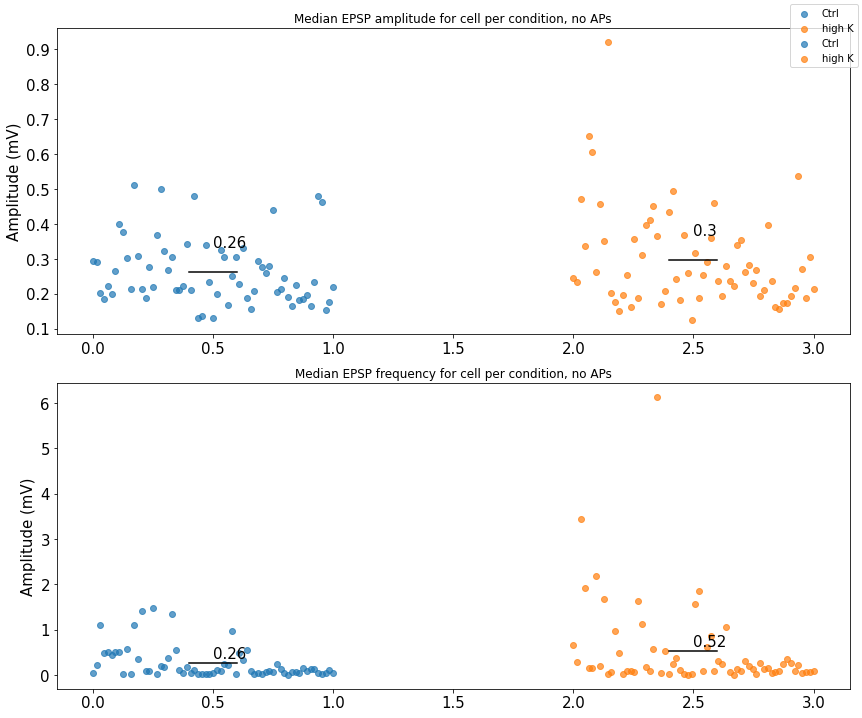

ValueError: The `sizes` list has the wrong number of values.

In [5]:
#      plotting results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

events_df_plot = events_df[(events_df['holding_minus_70_y_o_n'] == 'no') &
                                                             ) &
                           (events_df['recording_in'] != 'puff high K') &
                           (events_df['amplitude mean'] < 10)]

# median_amp_no_hold_no_temp_highK = events_df['amplitude median'][(events_df['holding_minus_70_y_o_n'] == 'no'                       ) &
#                 K_concentration'] == 8) &  (events_df['      (events_d== 'high K')].valces
# median_amp_no_hold_no_temp_Ctrl = events_df['amplitude median'][(events_df['holding_minus_70_y_o_n'] == 'no'] != 'puff high K') &
#                 K_concentration'] == 8) &  (events_df['recording_in'] == 'Ctrl')].valnes
# #remove APs
# median_amp_no_hold_no_temp_Ctrl = median_amp_no_hold_no_temp_Ctrl[median_amp_no_hold_no_temp_Ctrlplitue mean'] < 10)]

# freq_no_hold_no_temp_highK = events_df['frequency'][(events_df['holding_minus_70_y_o_n'] == 'no'                       ) &
#                 K_concentration'] == 8) &  (events_df['      (events_d== 'high K')].valces
# freq_no_hold_no_temp_Ctrl = events_df['frequency'][(events_df['holding_minus_70_y_o_n'] == 'no'] != 'puff high K') &
#                 K_concentration'] == 8) &  (events_df['recording_in'] == 'Ctrl')].valnes

median_amp_no_hold_no_temp_highK = events_df_plot[
    'amplitude median'][events_df['recording_in'] == 'high K'].values
median_amp_no_hold_no_temp_Ctrl = events_df_plot[
    'amplitude median'][events_df['recording_in'] == 'Ctrl'].values
freq_no_hold_no_temp_highK = events_df_plot['frequency'][events_df['recording_in']
                                                         == 'high K'].values
freq_no_hold_no_temp_Ctrlp= events_df_plot['frequency'][events_df['recording_in'] == 'Ctrl'].values

fig, ax = plt.subplots(2, 1, sharex=False, figsize=(12,itu))
ax[0].scatter(np.linspace(0, 1, len(median_amp_no_hold_no_temp_Ctrl)),
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, label='Ctrl')
ax[0].scatter(np.linspace(2, 3, len(median_amp_no_hold_no_temp_highK)),
              median_amp_no_hold_no_temp_highK, alpha=0.7, label='high K')
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanmean(median_amp_no_hold_no_temp_highK),
           np.nanmean(median_amp_no_hold_no_temp_hivhK)], c=
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, label='Ctrl')
ax[0].scatter(np.linspace(2, 3, len(median_amp_no_hold_no_temp_high
         K)), ==
              median_amp_no_hold_no_temp_highK, alpha=0.7, label='hi
         gh K') ==
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanm ean(median_amp_no_hold_no_temp_h
             ighK),==
           np.nanmean(median_am p_no_hold_no_temp_hivhK)], c=
             ==
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, labe
          l='Ctrl')=
ax[0].scatter(np.linspace(2, 3, len(median_amp_no_hold_no_temp_
          high=
         K)), ==
              median_amp_no_hold_no_temp_highK, alpha=0.7, l
         abel='hi ==
         gh K') ==
          ==
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanm ean(median_=_no_hold_no_temp_h
             ighK),===
           np.nanmean(median_am p_no_hold_no_temp_hivhK)], c=
             ==
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, labe
          l='Ctrl')=
ax[0].scatter(np.linspace(2, 3, len(median_amp_no_hold_no_temp_
          high=
         K)), ==
              median_amp_no_hold_no_temp_highK, alpha=0.7, l
         abel='hi ==
         gh K') ==
          ==
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanm ean(median_=_no_hold_no_temp_h
              ighK),===
           np.nanmean(median_am p_no_hold_no_temp_highK)], c=
             ==
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, labe
          l='Ctrl')=
ax[0].scatter
        (np.linspace(2, 3=op_color_dict[op], alpha=mp_==
          high=
         K)), ==
              median_amp_no_hold_no_temp_highK, alpha=0.7, l
         abel='hi ==
         gh K') ==
          ==
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanm ean(median_=_no_hold_no_temp_h
              ighK),===
           np.nanmean(median_am p_no_hold_no_temp_highK)], c=
             ==
              median_amp_no_hold_no_temp_Ctrl, alpha=0.7, labe
          l='Ctrl')=
ax[0].scatter
        (np.linspace(2, 3=op_color_dict[op], alpha=mp_==
          high=
         K)), ==
              median_amp_no_hold_no_temp_highK, alpha=0.7, l
         abel='hi ==
         gh K') ==
          ==
ax[0].plot([0.4, 0.6], [np.nanmean(median_amp_no_hold_no_temp_Ctrl),
           np.nanmean(median_amp_no_hold_no_temp_Ctrl)], c='k')
ax[0].plot([2.4, 2.6], [np.nanm ean(median_=_no_hold_no_temp_h
              ighK),===
           np.nanmean(median_am p_no_hold_no_temp_highK)], c='k')
             ==

          =
ax[0].text(0.
        5, np.nanmean(med=op_color_dict[op], alpha=+ 0==
          .07,=
           str(round(np.nanmean(median_amp_no_hold_no_temp_Ctrl), 2)), size=15, c='k')
ax[0].text(2.5, np.nanmean(median_amp_no_hold_no_temp_highK)
          + 0.07, ==
           str(round(np.nanmean(median_amp_no_hold_no_temp_hi
         ghK), 2)), size=15, c='k') ==
ax[0].set_title('Median EPSP amplitude for cell per condition, no APs')

ax[1].scatter(np.linspace(0, 1, len(freq_no=ld_no_temp_Ctrl)),
               freq_no_hold_no_temp_Ctrl, al==0.7, label='Ctrl')
ax[1].scatter(np.linspace(2, 3, len(freq_no_hold_no_temp_highK)),
              freq_no_hold_no_temp_highK, alpha=0.7, label='high K')
ax[1].plot([0.4, 0.6], [np.nanmean(freq_no_hold_no_temp_Ctrl),
           np.nanmean(freq_no_hold_no_temp_Ctrl)], c='k')
ax[1].plot([2
        .4, 2.6], [np.nan=op_color_dict[op], alpha=K),==
           np.nanmean(freq_no_hold_no_temp_highK)], c='k')

ax[1].text(0.5, np.nanmean(freq_no_hold_no_temp_Ctrl) + 0.1,
           str(round(np.nanmean(freq_no_hold_no_temp_Ctrl), 2)), size=15, c='k')
ax[1].text(2.5, np.nanmean(freq_no_hold_no_temp_highK) + 0.1,
           str(round(np.nanmean(freq_no_hold_no_temp_highK), 2)), size=15, c='k')
ax[1].set_title('Median EPSP frequency for cell per condition, no APs')

ax[0].set_ylabel('Amplitude (mV)', fontsize=15)
ax[1] .set_ylabel('Amplitude (mV)', fontsize=15)

ax[0].tick_params(axis='y', labelsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_pa
        rams(axis='x', la=op_color_dict[op], alpha===

fig.tight_layout()
fig.patch.set_facecolor('white')
fig.legend()

plt.show()

# #connect the lines -- FIX and FINALIZE
for c, cell in enumerate(df_plot['cell_ID_new']):
    # indx = index_s[c]
    x_K = df_plot['x'].loc[df_plot['cell_ID_new'] == cell].tolist()[0]
    x1 = [x_plot[0][c], x_K]
    y = df[param][df['cell_ID_new'] == cell]
    op = df_plot['OP'][df_plot['cell_ID_new'] == cell].tolist()[0]
    plt.plot(
        x1, y, '-', color=op_color_dict[op], alpha=0.5, linewidth=2, zorder=1)

# #seabornb plots to see trend

# sns.lineplot(x='recording_in', y='amplitude median', data=events_df_plot, palette='viridis', size='cell_ID', sizes=list(np.ones(24)+1),legend=False, errorbar=None)
# plt.show()
# sns.lineplot(x='recording_in', y='frequency', data=events_df_plot, palette='viridis', size='cell_ID', sizes=list(np.ones(24)+1),legend=False, errorbar=None)
# plt.show()

In [7]:
events_df_plot['temperature']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
171   NaN
177   NaN
178   NaN
179   NaN
180   NaN
Name: temperature, Length: 129, dtype: float64

### Prepare files for analysis with Barbara's algorithm - manual analysis <a name ='6'>
    
Take all of the files which enter into the plots 
Take sweep 2 and 2nd to last and 20 seconds each - at the end of the sweep
Run through Barbara’s algorithm and annotate the EPSPs manually with proof_read_results.py
Compare to automatic detection

In [ ]:

import pandas as pd
import sorting_functions as sort
import shutil
import os
import human_characterisation_functions as hcf

human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
EPSPs_meta_path = human_dir + 'meta_events/EPSPs/meta_dfs/2023-12-06EPSPs_meta.xlsx'
meta_complete = pd.read_excel(EPSPs_meta_path)
patcher = 'Verji'
dest_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/meta_events/EPSPs_files/'

for OP in meta_complete.OP.unique():
    work_dir_events = sort.get_work_dir(human_dir, OP, patcher)
    #      moving files directly to the recordings folder in event analysis
    for f in meta_complete['Name of recording'][meta_complete['OP'] == OP]:
        shutil.copy(os.path.join(work_dir_events, f), dest_dir)

swps_to_delete, cut_from_dp,      swp_lens = [] ,   [ ] , []
file_list = sorted(os.listdir(dest_dir))
for fn in meta_complete['Name of recording']:
    data_dict = hcf.load_traces(dest_dir + fn)
    ch0 = list(data_dict)[0]
    sweep_len = np.shape(data_dict[ch0][0])[0]
    sweep_num = np.shape(data_dict[ch0][0])[1]
    swp_lens.append(sweep_len/20_000)

    # if sweep_num > 5:
    #     all_swps = np.arange(0,sweep_num-1)
    #     keep_indx = [1, sweep_num-2]
    #     swps_to_delete.append(np.delete(all_swps, keep_indx))
    # else:
    #     swps_to_delete.append([])

    # if sweep_len > 400_000:
    #     cut_from_dp.append(400_000)
    # else:
    #     cut_from_dp.append(0)

# meta_complete['swps_to_delete'] = swps_to_delete
# meta_complete['Cut from datapoint'] = cut_from_dp
#      meta_complete.insert(6, 'sweep_len (ms)', swp_lens)

# meta_complete.to_excel(human_dir + 'meta_events/EPSPs/meta_dfs/2023-12-06EPSPs_meta_for_Barbs_algorithm.xlsx')
# meta_complete.to_excel('/Users/verjim/spontaneous-postsynaptic-currents-detection/metadata/metadata.xlsx')